In [9]:
from pipeline_creation import create_pipeline, make_list_of_elements, weights_to_apply, equalize_histogram
from utils import get_random_indices, get_training_file_paths
from from_preprocessing_to_training import AttentionUnet, Losses, LoadPreprocessImages

import matplotlib.pyplot as plt
import cv2
import json
from tqdm import tqdm
import numpy as np

import tensorflow as tf 
from tensorflow import keras
# from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from keras import backend as K

In [2]:
from transformers import TFSegformerForSemanticSegmentation

In [3]:
with open('config.json') as f:
    config = json.load(f)

In [4]:
class LoadPreprocessImagesBis:
    @staticmethod
    def equalize_histogram(image, convert_to_tensors=True):
        """
        Apply histogram equalization to an RGB image.

        Parameters:
        - image (tf.Tensor): Input RGB image.

        Returns:
        - tf.Tensor: Image after histogram equalization.
        """
        # Convert RGB to YUV
        image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        # Apply histogram equalization to the Y channel
        image_yuv[:,:,0] = cv2.equalizeHist(image_yuv[:,:,0])
        # Convert YUV back to RGB
        image_output = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)

        if convert_to_tensors:
            # Convert back to tensor
            image_output = tf.convert_to_tensor(image_output, dtype=tf.float32)
        return image_output

    @staticmethod
    def adap_hist_equalize(img):
        # histogram equalization
        equalized_image = cv2.equalizeHist(img)
        # Adaptive histogram equalization is supposed to be more robust
        # CLAHE = Contrast Limited Adaptive Histogram Equalization
        # Create a CLAHE object
        clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
        # Apply CLAHE to the image
        adap_equalized_image = clahe.apply(equalized_image)
        return adap_equalized_image

    @staticmethod
    def load_preprocess_images(rgb, equalize, add_noise, noise=2, max_samples=None, img_row=256, img_col=256, gt_chan=1, test_split=0.2):
        if rgb:
            img_chan = 3
        else:
            img_chan = 1

        img_list, gt_list = get_training_file_paths()

        if max_samples:
            random_indices = get_random_indices(range(len(img_list)), max_samples)
            random_indices.sort()
            img_list = np.array(img_list)[random_indices].tolist()
            gt_list = np.array(gt_list)[random_indices].tolist()

        num_imgs = len(img_list)

        if rgb:
            imgs = np.zeros((num_imgs, img_row, img_col, 3))
        else:
            imgs = np.zeros((num_imgs, img_row, img_col, 3))
        gts = np.zeros((num_imgs, img_row, img_col))

        for i in tqdm(range(num_imgs)):
            tmp_img = plt.imread(img_list[i])
            tmp_gt = plt.imread(gt_list[i])

            img = cv2.resize(tmp_img, (img_col, img_row), interpolation=cv2.INTER_NEAREST)
            gt = cv2.resize(tmp_gt, (img_col, img_row), interpolation=cv2.INTER_NEAREST)

            if add_noise:
                img = (img + noise * img.std() * np.random.random(img.shape)).astype(np.uint8)
                
            if rgb:
                if equalize:
                    img = LoadPreprocessImages.equalize_histogram(img, convert_to_tensors=False)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                if equalize:
                    img = LoadPreprocessImages.adap_hist_equalize(img)

            if img.max() > 1:
                img = img / 255.
            if gt.max() > 1:
                gt = gt / 255.
            
            imgs[i] = np.stack([img]*3, axis=2)# tf.transpose(np.stack([img]*3, axis=2), (2, 0, 1)).numpy()# img
            gts[i] = gt

        indices = np.arange(0, num_imgs, 1)

        imgs_train, imgs_test, \
        imgs_mask_train, imgs_mask_test, \
        trainIdx, testIdx = train_test_split(imgs, gts, indices, test_size=test_split)

        # if not rgb:
        #     imgs_train = np.expand_dims(imgs_train, axis=3)
        #     imgs_test = np.expand_dims(imgs_test, axis=3)

        imgs_mask_train = np.expand_dims(imgs_mask_train, axis=3)
        imgs_mask_test = np.expand_dims(imgs_mask_test, axis=3)

        return imgs_train, imgs_mask_train, imgs_test, imgs_mask_test


In [151]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def create_mask(pred_mask, idx=0):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[idx]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))



def display(display_list):
    plt.figure(figsize=(12, 12))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


In [10]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
import cv2

In [241]:
a = np.array([])

In [242]:
a = np.append(a, {'a':1, 'b':2})

In [244]:
tf.convert_to_tensor(a)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type dict).

In [245]:
class orthosSequence(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, input_img_paths, target_img_paths, rgb, add_noise, noise=2, img_size=(256, 256), smooth = 0):
        
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.smooth = smooth
        self.rgb = rgb
        self.add_noise = add_noise
        self.noise = noise
        self.img_size = img_size

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        x = np.array([])# np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j in range(len(batch_input_img_paths)):
            img_path = batch_input_img_paths[j]
            mask_path = batch_target_img_paths[j]
            img = load_img(img_path, target_size=self.img_size)
            img = np.asarray(img)
            if self.add_noise:
                img = (img + self.noise * img.std() * np.random.random(img.shape)).astype(np.uint8)
            if not self.rgb:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            if img.max() > 1:
                img = img/255.
            # x[j] = img if self.rgb else np.stack([img]*3, axis=2)#gaussian_filter(img, sigma=(self.smooth,self.smooth,0))
            
            mask = load_img(mask_path, target_size=self.img_size, color_mode="grayscale")
            mask = np.asarray(mask)
            if mask.max() > 1:
                mask = mask/255.
            
            x = np.append(x, {'pixel_values': img,
            'labels':np.expand_dims(mask, 2)})
            
        return x # tf.convert_to_tensor(x)

In [246]:
max_samples = 20

In [247]:
input_img_paths, target_img_paths = get_training_file_paths()

if max_samples:
    random_indices = get_random_indices(range(len(input_img_paths)), max_samples)
    random_indices.sort()
    input_img_paths = np.array(input_img_paths)[random_indices].tolist()
    target_img_paths = np.array(target_img_paths)[random_indices].tolist()

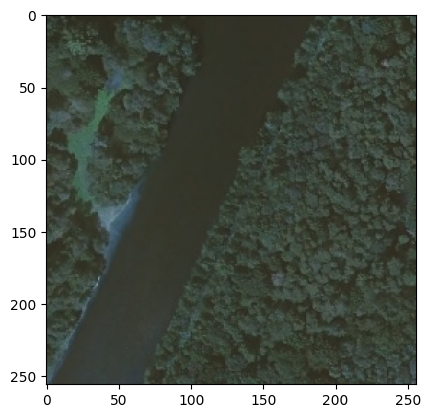

In [248]:
path = input_img_paths[1]# 'vignettes/rgb\\rgb_315_6775\\rgb_35_319576_6775576.jpg'
img = np.asarray(load_img(path, target_size=(256, 256)))
plt.imshow(img)

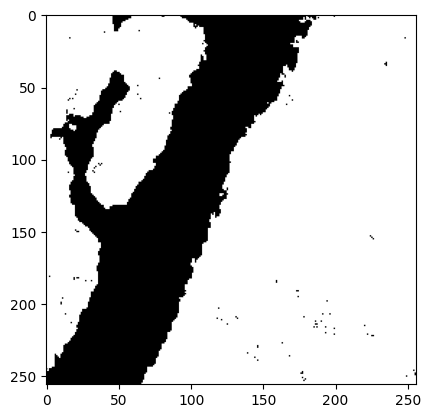

In [249]:
path = target_img_paths[1]# 'vignettes/rgb\\rgb_315_6775\\rgb_35_319576_6775576.jpg'
img = np.asarray(load_img(path, target_size=(256, 256)))
plt.imshow(img)

In [250]:
train_input_img_paths, val_input_img_paths, train_target_img_paths, val_target_img_paths = train_test_split(input_img_paths, target_img_paths, test_size=0.1, shuffle=False)

In [251]:
epochnum = 20
img_size = 256
BS = 4

# Instantiate data Sequences for each split
train_gen = orthosSequence(batch_size=BS, input_img_paths=train_input_img_paths, target_img_paths=train_target_img_paths, rgb=False, add_noise=True)
val_gen = orthosSequence(batch_size=BS, input_img_paths=val_input_img_paths, target_img_paths=val_target_img_paths, rgb=False, add_noise=True)

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
# model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryAccuracy()])

# callbacks = [
#     keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
# ]

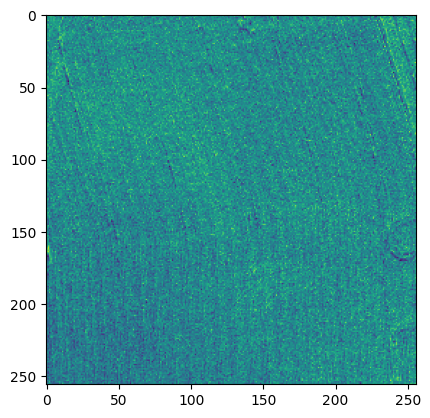

In [252]:
plt.imshow(train_gen.__getitem__(2)[0]['pixel_values'])

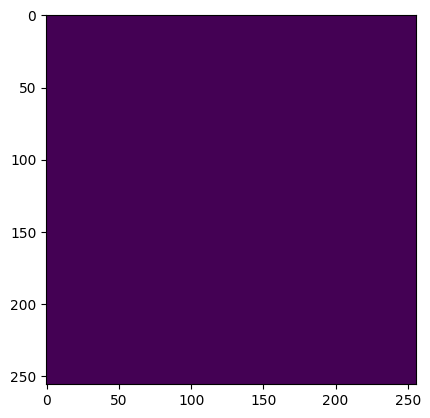

In [253]:
plt.imshow(train_gen.__getitem__(2)[0]['labels'])

In [254]:
from transformers import TFSegformerForSemanticSegmentation# , TFSwinForMaskedImageModeling

model_checkpoint = "nvidia/mit-b0" # "facebook/maskformer-swin-base-ade"# "nvidia/mit-b0" "facebook/mask2former-swin-small-ade-semantic"
id2label = {0: "background", 1: "foreground"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)


Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [255]:
print(model.summary())

Model: "tf_segformer_for_semantic_segmentation_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  395778    
 codeHead)                                                       
                                                                 
Total params: 3715170 (14.17 MB)
Trainable params: 3714658 (14.17 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________
None


In [256]:
LR = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer)
callbacks = [DisplayCallback(val_gen), 
             keras.callbacks.EarlyStopping(patience=3, start_from_epoch=5),
             # keras.callbacks.ModelCheckpoint(config['models_dir']+f"intermediary_SegFormer_B&W_{int(len(imgs_train))}_trains_no_equalizing_with_normalizing_with_noise_{epochnum}_epochs_img_size_{img_size}_LR_{LR}_BS_4".replace('.', '_').replace('-','_'), save_best_only=True)
]

In [257]:
len(train_gen)

4

In [258]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    callbacks=callbacks,
    epochs=epochnum,
)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type dict).

In [20]:
model.save_pretrained((config['models_dir'] + 'SegFormer_B&W_' + str(int(len(imgs_train))) + '_trains' + '_epochs-' + str(epochnum) + f'_no_equalizing_with_normalizing_with_2_noise_img_size_{img_size}_LR_{LR}_BS_{BS}').replace('.', '_').replace('-','_'))

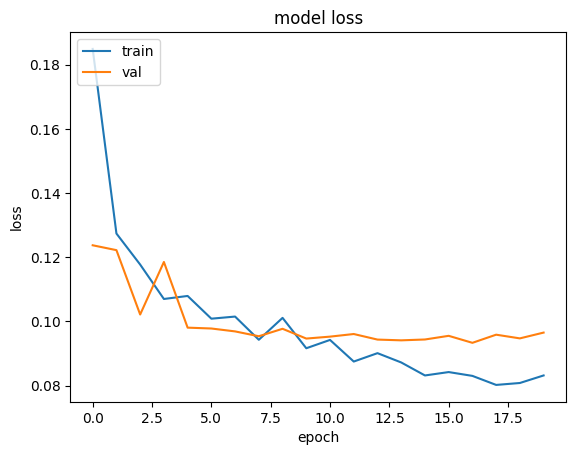

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
model_path = "output_models/SegFormer_B&W_4800_trains_epochs_20_no_equalizing_with_normalizing_with_2_noise_img_size_256_LR_6e_05_BS_4"
loaded_model = TFSegformerForSemanticSegmentation.from_pretrained(model_path,
                                                                  local_files_only=True)


All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at output_models/SegFormer_B&W_4800_trains_epochs_20_no_equalizing_with_normalizing_with_2_noise_img_size_256_LR_6e_05_BS_4.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


In [20]:
LR = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
loaded_model.compile(optimizer=optimizer)

In [21]:
loaded_model.summary()

Model: "tf_segformer_for_semantic_segmentation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  395778    
 codeHead)                                                       
                                                                 
Total params: 3715170 (14.17 MB)
Trainable params: 3714658 (14.17 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [22]:
loaded_model.evaluate(test_ds)
# val_preds = model.predict(val_ds)

15/15 [==============================] - 63s 2s/step - loss: 0.0810


0.0809955894947052

In [23]:
val_preds = loaded_model.predict(test_ds)

15/15 [==============================] - 50s 2s/step


1/1 [==============================] - 21s 21s/step


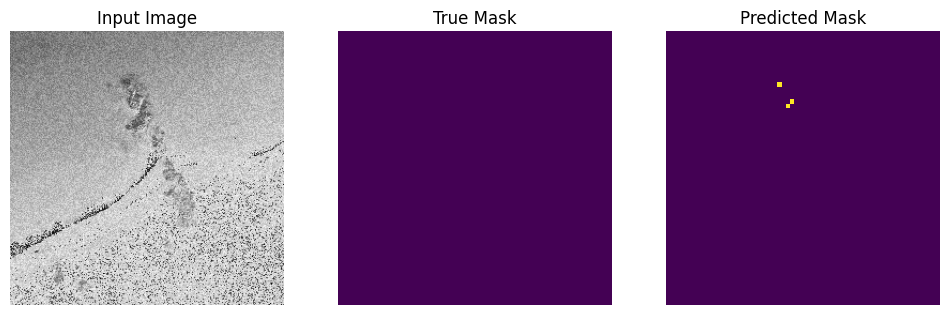

1/1 [==============================] - 2s 2s/step


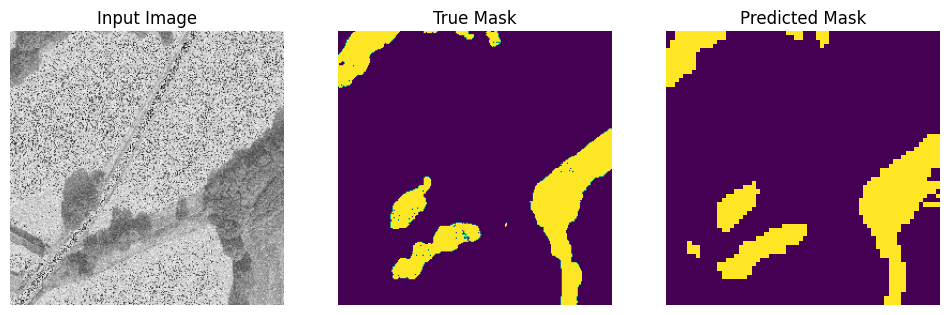

1/1 [==============================] - 2s 2s/step


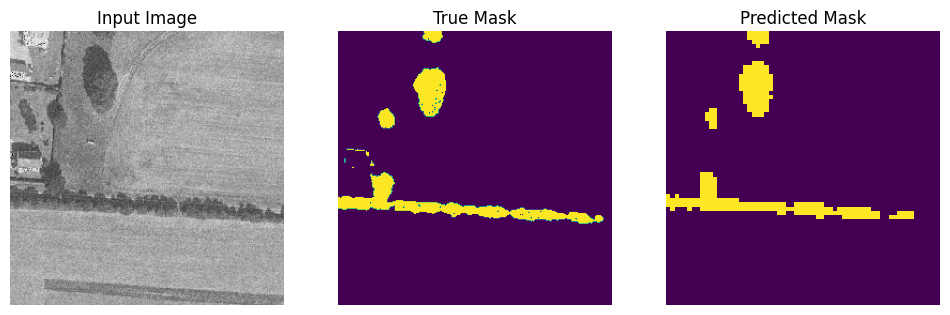

1/1 [==============================] - 2s 2s/step


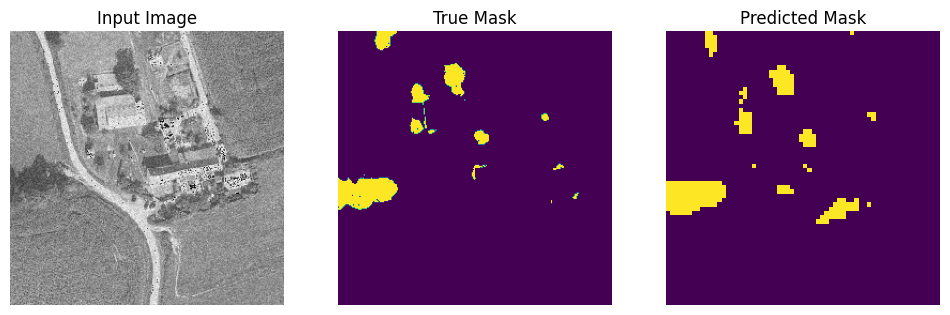

1/1 [==============================] - 3s 3s/step


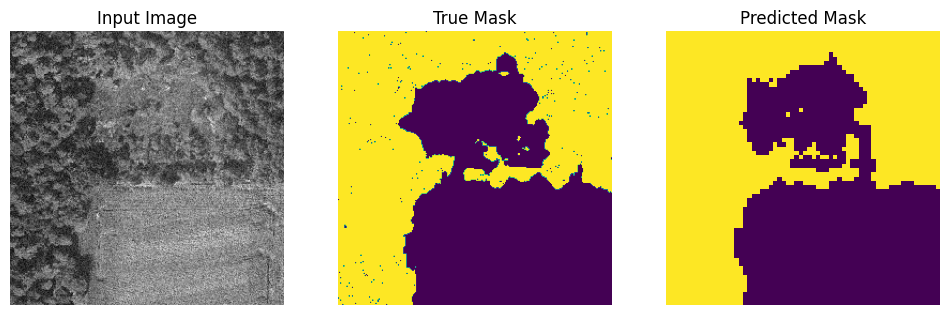

1/1 [==============================] - 2s 2s/step


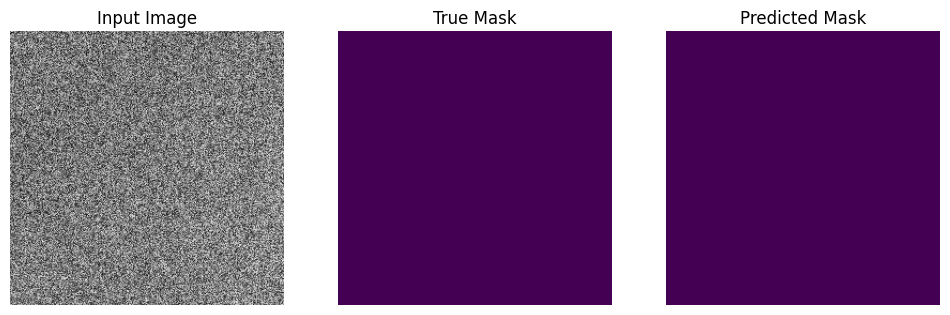

1/1 [==============================] - 2s 2s/step


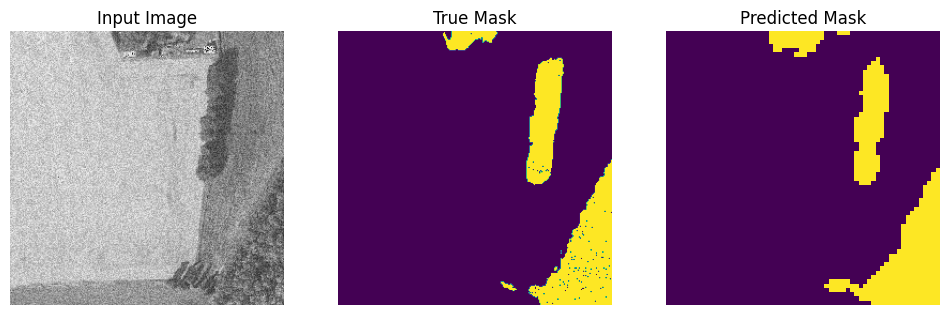

1/1 [==============================] - 2s 2s/step


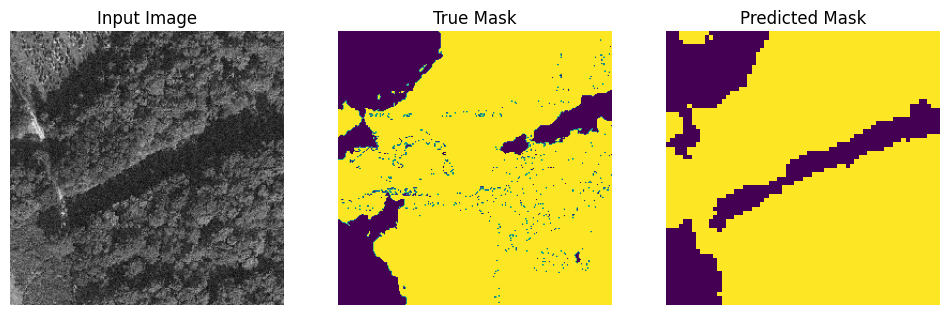

1/1 [==============================] - 2s 2s/step


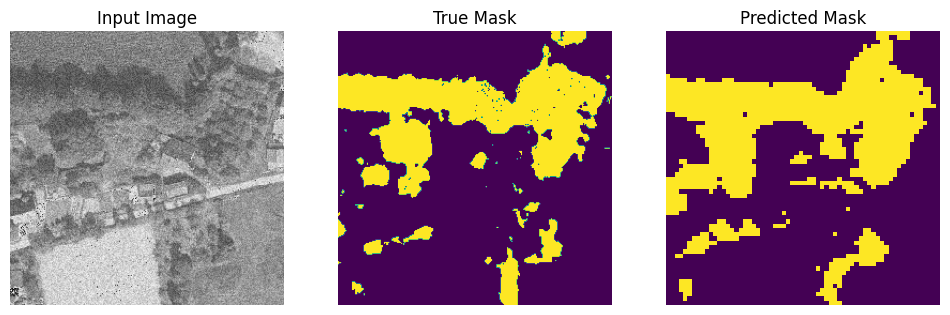

1/1 [==============================] - 2s 2s/step


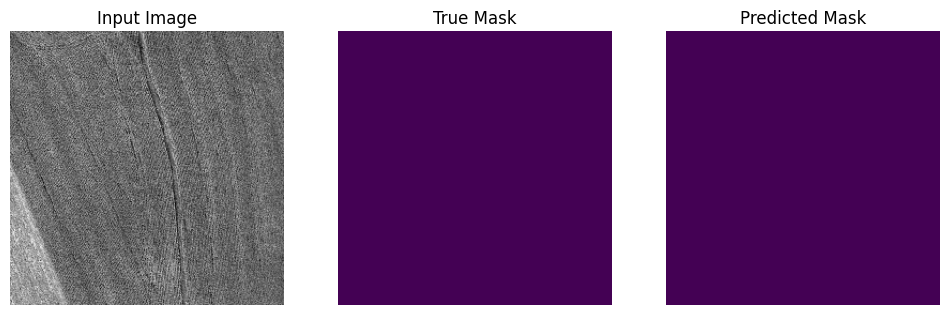

In [24]:
for sample in test_ds.take(10):
    images, masks = sample["pixel_values"], sample["labels"]
    masks = tf.expand_dims(masks, -1)
    pred_masks = loaded_model.predict(images).logits
    images = tf.transpose(images, (0, 2, 3, 1))
    display([images[0], masks[0], create_mask(pred_masks)])